In [1]:
!apt-get install -y libturbojpeg0-dev
!pip install jpeg4py

!pip install efficientnet_pytorch

!pip install mlflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libjpeg-turbo8 libjpeg-turbo8-dev libturbojpeg
The following NEW packages will be installed:
  libturbojpeg libturbojpeg0-dev
The following packages will be upgraded:
  libjpeg-turbo8 libjpeg-turbo8-dev
2 upgraded, 2 newly installed, 0 to remove and 97 not upgraded.
Need to get 615 kB of archives.
After this operation, 1240 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libjpeg-turbo8-dev amd64 1.5.2-0ubuntu5.18.04.4 [225 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libjpeg-turbo8 amd64 1.5.2-0ubuntu5.18.04.4 [110 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libturbojpeg amd64 1.5.2-0ubuntu5.18.04.4 [126 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libturbojpeg0-dev amd64 1.5.2-0ubuntu5.18.04.4 [153 

     |████████████████████████████████| 84 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 124 kB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 2.6 MB/s  eta 0:00:01
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=a4805848530788444721c8f59c23af32443394de3e4eea17c0ccc964be933a33
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for prometheus-flask-exporter: filename=prometheus_flask_exporter-0.18.1-py3-none-any.whl size=17157 sha256=41e20cb672040750fb3a7d46dc22ac7fe1591ee2be39c50ad87d750b35c57fd1
  Stored in directory: /root/.cache/pip/wheels/c4/b6/b5/e76659f3b2a3a226565e27f0a7eb7a3ac93c3f4d68acfbe617
  Created wheel for databricks-cli: filename=databricks_cli-0.14.1-py3-none-any.whl size=100576 sha256=d5f123ad3e706693db0d40735a1317c1ac8ea2c0d38f4b0f96d39444cf17d242
  Stored in directory: /root/.cache/pip/wheels/7f/d9/25/baefac3eda0

In [2]:
!nvidia-smi

Fri Nov 27 19:20:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import jpeg4py as jpeg
import shutil
import os
from PIL import Image
import zipfile
import time

import torch
import torch.nn as nn
import torchvision
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2

import mlflow

In [4]:
# configure mlflow run
MLF_TRACK_URI = 'http://130.61.20.111:5000'
MLF_EXP_NAME = 'cassava_exp1'
MLF_RUN_NAME = 'cassava-run6'

mlflow.set_tracking_uri(MLF_TRACK_URI)
mlflow.set_experiment(MLF_EXP_NAME)

# mark the start of the run
mlflow.start_run(run_name = MLF_RUN_NAME)

<ActiveRun: >

In [5]:
TRAIN_DIR = '/kaggle/input/cassava-leaf-disease-classification/train_images'

orig_files = os.listdir(TRAIN_DIR)

train_files = orig_files[:19000]
valid_files = orig_files[19000:]

len(orig_files), len(train_files), len(valid_files)

(21397, 19000, 2397)

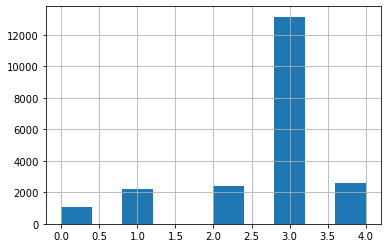

In [6]:
TRAIN_CSV = '/kaggle/input/cassava-leaf-disease-classification/train.csv'

train_csv = pd.read_csv(TRAIN_CSV)

train_csv['label'].hist();

In [7]:
train_files[0]

'3191091730.jpg'

In [8]:
# dataset


#qui definisco le trasformazioni
SIZE = 300

# le trasformazioni devono essere completate (OK for now)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# my_transforms = transforms.Compose([transforms.Resize((SIZE, SIZE)), transforms.ToTensor(), normalize])

albumentations_transform_train = A.Compose([
    A.Resize(SIZE, SIZE), 
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

albumentations_transform_valid = A.Compose([
    A.Resize(SIZE, SIZE), 
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

class CassavaDataset(Dataset):
    def __init__(self, files, transforms=None):
        self.items = files
        self.length = len(files)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        f_name = self.items[idx]
        
        label = int(train_csv[train_csv.image_id == f_name]['label'].values)
        
        img = jpeg.JPEG(os.path.sep.join([TRAIN_DIR, f_name])).decode()

        img = self.transforms(image=img)['image']
        
        # return img, label
        return img, label
    
    def __len__(self):
        return self.length

In [9]:
train_ds = CassavaDataset(train_files, transforms=albumentations_transform_train)
# no augmentation
valid_ds = CassavaDataset(valid_files, transforms=albumentations_transform_valid)

img, label = train_ds[0]

img.shape, label

(torch.Size([3, 300, 300]), 3)

In [10]:
BATCH_SIZE = 32

train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)
valid_dl = DataLoader(valid_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)

In [11]:
N_CLASS = 5

model = EfficientNet.from_pretrained('efficientnet-b2')

# for name, param in model.named_parameters():
#    if ("bn" not in name):
#        param.requires_grad = False

num_ftrs = model._fc.in_features

model._fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(512, N_CLASS)
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [12]:
model.cuda()

model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [13]:
def show_model_params(model):
        numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
        print('List model parameters')
        print(sum(numel_list), numel_list)

show_model_params(model)

List model parameters
8424967 [864, 32, 32, 288, 32, 32, 256, 8, 256, 32, 512, 16, 16, 144, 16, 16, 64, 4, 64, 16, 256, 16, 16, 1536, 96, 96, 864, 96, 96, 384, 4, 384, 96, 2304, 24, 24, 3456, 144, 144, 1296, 144, 144, 864, 6, 864, 144, 3456, 24, 24, 3456, 144, 144, 1296, 144, 144, 864, 6, 864, 144, 3456, 24, 24, 3456, 144, 144, 3600, 144, 144, 864, 6, 864, 144, 6912, 48, 48, 13824, 288, 288, 7200, 288, 288, 3456, 12, 3456, 288, 13824, 48, 48, 13824, 288, 288, 7200, 288, 288, 3456, 12, 3456, 288, 13824, 48, 48, 13824, 288, 288, 2592, 288, 288, 3456, 12, 3456, 288, 25344, 88, 88, 46464, 528, 528, 4752, 528, 528, 11616, 22, 11616, 528, 46464, 88, 88, 46464, 528, 528, 4752, 528, 528, 11616, 22, 11616, 528, 46464, 88, 88, 46464, 528, 528, 4752, 528, 528, 11616, 22, 11616, 528, 46464, 88, 88, 46464, 528, 528, 13200, 528, 528, 11616, 22, 11616, 528, 63360, 120, 120, 86400, 720, 720, 18000, 720, 720, 21600, 30, 21600, 720, 86400, 120, 120, 86400, 720, 720, 18000, 720, 720, 21600, 30, 21600, 72

In [14]:
EPOCHS = 20

lr = 6e-3

optim = SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=lr, steps_per_epoch=len(train_dl), epochs=EPOCHS)

# loss_fn = nn.NLLLoss()
loss_fn = nn.CrossEntropyLoss()

In [15]:
# log parameters on mlflow
mlflow.log_param("lr", lr)
mlflow.log_param("epochs", EPOCHS)
mlflow.log_param("SIZE", SIZE)

In [16]:
# rifattorizzo introducendo queste due funzioni prese da Kaggle

# in realtà da la somma delle label previste correttamente (va poi divisa per il numro di sample)
def accuracy(preds, target):
    preds = preds.argmax(dim=1)
    return (preds == target).float().mean()
    
def one_epoch(model, dl, loss_func, opt=None, lr_schedule=None):
    running_loss = 0.
    running_acc = 0
    
    n_batches = len(dl)
    
    for xb, yb in dl:
        # sposta sulla GPU
        xb, yb = xb.cuda(), yb.cuda()
        
        # forward prop
        preds = model(xb)
        loss = loss_func(preds, yb)
        
        # back prop
        # i check sono per l'uso in validazione
        # ove non vogliamo back prop
        if opt is not None:
            opt.zero_grad()
            loss.backward()
            opt.step()
            if lr_schedule is not None:
                lr_schedule.step()
    
        running_acc += accuracy(preds, yb).item()
        running_loss += loss.item()
        
    return (running_loss / n_batches), (running_acc / n_batches)

In [17]:
hist = []

#
# Training Loop
#

valid_dl = DataLoader(valid_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)

# for saving
best_val_acc = 0.

for epoch in range(EPOCHS):
    
    # all'inizio di ogni epoch fa il reshuffle del dataset di train (no val)
    train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)
    
    tStart = time.time()
    # One Epoch
    model.train()
    print('training...')
    avg_loss, avg_train_acc = one_epoch(model, train_dl, loss_fn, optim, scheduler)
    
    mlflow.log_metric("avg_loss", avg_loss)
    mlflow.log_metric("train_acc", avg_train_acc)
    
    model.eval()
    with torch.no_grad():
        # importante passare opt=None duranta la validation non si fa training
        print('evaluating...')
        avg_val_loss, avg_val_acc = one_epoch(model, valid_dl, loss_fn, opt=None, lr_schedule=None)
        
        mlflow.log_metric("avg_val_loss", avg_val_loss)
        mlflow.log_metric("val_acc", avg_val_acc)
    
    tEla = time.time() - tStart
    print('[ela=%.1f s.] Epoch: %d, Loss: %f, Acc: %f, Val loss: %f, Val acc: %f' %(tEla, epoch + 1, avg_loss, avg_train_acc, avg_val_loss, avg_val_acc))
    
    hist.append([epoch, avg_loss, avg_val_loss])
    
    # saving model
    if avg_val_acc > best_val_acc:
        torch.save(model.state_dict(), 'cassava1.pt')
        best_val_acc = avg_val_acc
        mlflow.log_metric("best_val_acc", best_val_acc)

training...
evaluating...
[ela=285.0 s.] Epoch: 1, Loss: 1.079877, Acc: 0.606166, Val loss: 0.832743, Val acc: 0.698405
training...
evaluating...
[ela=265.4 s.] Epoch: 2, Loss: 0.785838, Acc: 0.702301, Val loss: 0.636240, Val acc: 0.778075
training...
evaluating...
[ela=266.7 s.] Epoch: 3, Loss: 0.587501, Acc: 0.788685, Val loss: 0.465764, Val acc: 0.839239
training...
evaluating...
[ela=268.1 s.] Epoch: 4, Loss: 0.484198, Acc: 0.828809, Val loss: 0.405497, Val acc: 0.862658
training...
evaluating...
[ela=268.9 s.] Epoch: 5, Loss: 0.426426, Acc: 0.851273, Val loss: 0.381164, Val acc: 0.873908
training...
evaluating...
[ela=269.5 s.] Epoch: 6, Loss: 0.393480, Acc: 0.864180, Val loss: 0.372477, Val acc: 0.870661
training...
evaluating...
[ela=267.0 s.] Epoch: 7, Loss: 0.362490, Acc: 0.873053, Val loss: 0.358394, Val acc: 0.873707
training...
evaluating...
[ela=269.9 s.] Epoch: 8, Loss: 0.340153, Acc: 0.882734, Val loss: 0.369370, Val acc: 0.875704
training...
evaluating...
[ela=268.3 s.]

In [18]:

import numpy as np

def plot_hist(hist):
    vet_hist = np.array(hist)
    epochs = vet_hist[: , 0]
    losses = vet_hist[: , 1]
    val_losses = vet_hist[: , 2]
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, losses)
    plt.plot(epochs, val_losses)
    plt.legend(['train', 'val'])
    plt.grid();

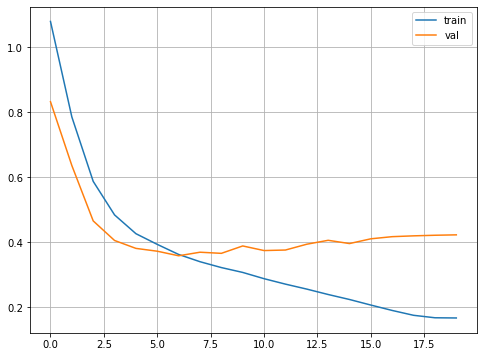

In [19]:
plot_hist(hist)

In [20]:
# mark the end of the run
mlflow.end_run()